In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

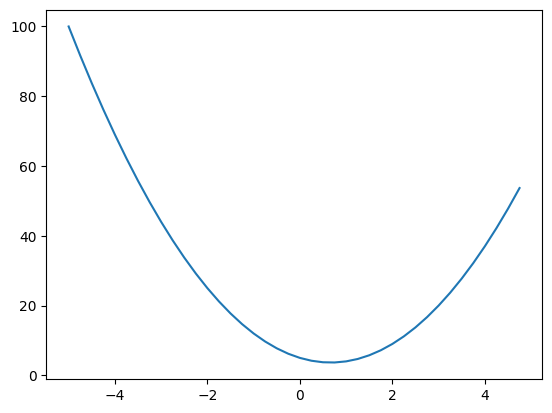

In [4]:
xs = np.arange(-5, 5, .25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.000000001
x = 2/3
(f(x + h) - f(x))/h

0.0

In [6]:
# lets get more complex
a = 2.0
b = 3.0
c = 10.0
d = a*b + c
print(d)

16.0


In [7]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b +c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [57]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __sub__(self, other):
    return self + (-other)

  def __radd__(self, other):
    return self + other

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self, ), f'**{other}')

    def _backward():
      self.grad += other * self.data**(other - 1) * out.grad

    out._backward = _backward
    return out

  def __rmul__(self, other):
    return self * other

  def __truediv__(self, other):
    return self * other**-1

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [9]:
from graphviz import Digraph

def trace(root):
    nodes ,edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
              edges.add((child, v))
              build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape="record")
        if n._op:
          dot.node(name = uid + n._op, label = n._op)
          dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot. edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

Caclualte the gradients by recursvively multiplying the local derivatives by the previous derivative, where we start from the end. In this case, the end is L.

In [12]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d * f; L.label = 'L'

L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0
e.grad = -2.0
a.grad = 6.0
b.grad = -4.0

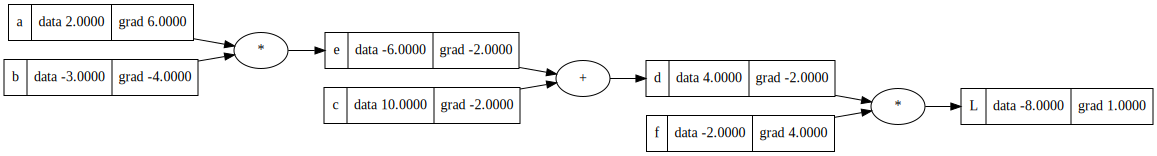

In [13]:
draw_dot(L)

In [14]:
def lol():
  h = 0.0001
  a = Value(2.0, label="a")
  b = Value(-3.0, label="b")
  c = Value(10.0, label="c")
  e = a*b; e.label = "e"
  d = e + c; d.label = "d"
  f = Value(-2.0, label="f")
  L = d * f; L.label = "L"
  L1 = L.data

  a = Value(2.0 + h, label="a")
  b = Value(-3.0, label="b")
  c = Value(10.0, label="c")
  e = a*b; e.label = "e"
  d = e + c; d.label = "d"
  f = Value(-2.0, label="f")
  L = d * f; L.label = "L"
  L2 = L.data

  print((L2 - L1)/h)
lol()

6.000000000021544


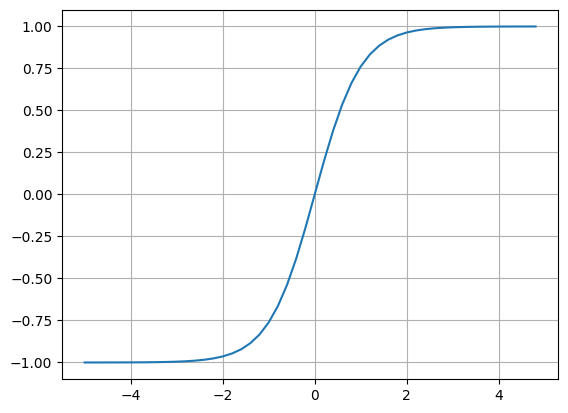

In [15]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid();

In [16]:
# inputs x1, x2
x1 = Value(2.0, label = "x1")
x2 = Value(0.0, label = "x2")

# weights w1, w2
w1 = Value(-3.0, label = "w1")
w2 = Value(1.0, label = "w2")

b = Value(6.8813735870195432, label = "b")

# x1 * w1 + x2 * w2 + b
x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh()

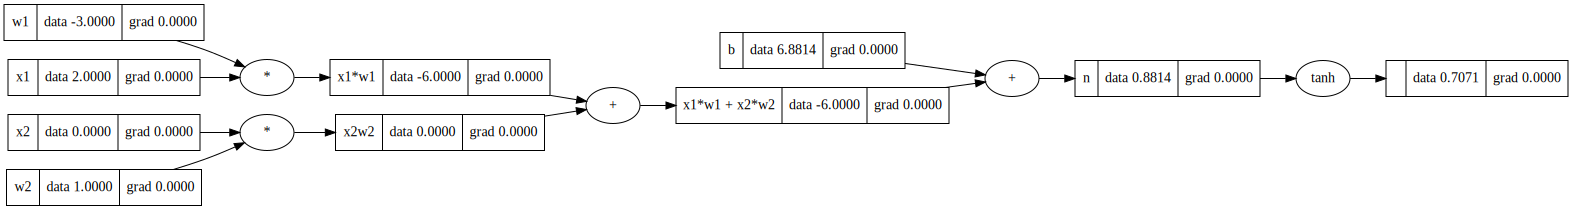

In [17]:
draw_dot(o)

Gradient descent done manually...

In [18]:
o.grad = 1

In [19]:
# o = tanh(n)
# do/dn = 1 - o**2
n.grad = .5

In [20]:
x1w1x2w2.grad =0.5
b.grad = 0.5

In [21]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [22]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [23]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

Gradient descent done with ._backward() function

In [24]:
o.grad = 1.0
o._backward()

In [25]:
n._backward()

In [26]:
b._backward()
x1w1x2w2._backward()

In [27]:
x2w2._backward()
x1w1._backward()

How about not having to call ._backward() manually? Instead, we can use topological sort and call ._backward() on the nodes in that ordering.

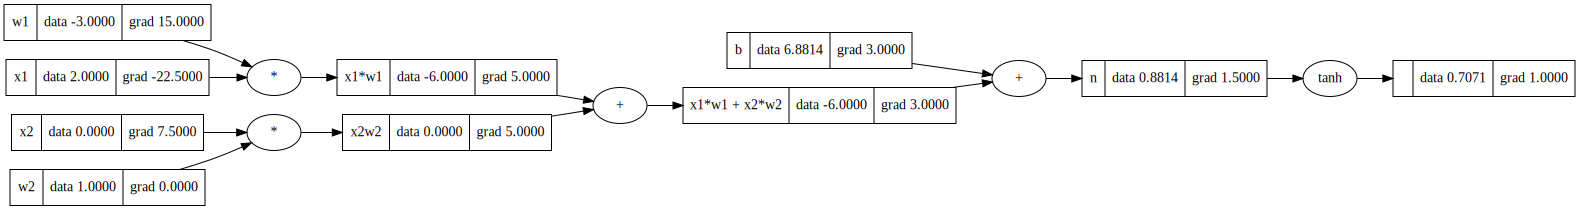

In [28]:
o.grad = 1

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)

for node in reversed(topo):
  node._backward()

draw_dot(o)

In [29]:
# inputs x1, x2
x1 = Value(2.0, label = "x1")
x2 = Value(0.0, label = "x2")

# weights w1, w2
w1 = Value(-3.0, label = "w1")
w2 = Value(1.0, label = "w2")

b = Value(6.8813735870195432, label = "b")

# x1 * w1 + x2 * w2 + b
x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh()

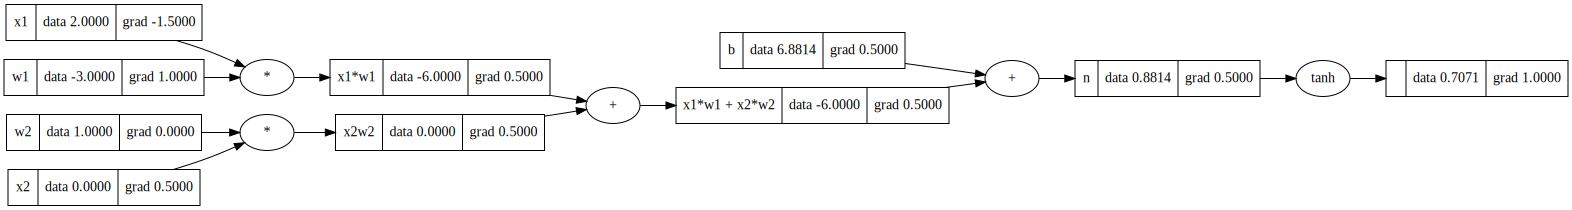

In [30]:
o.backward()
draw_dot(o)

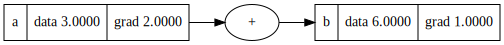

In [31]:
a = Value(3.0, label = 'a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

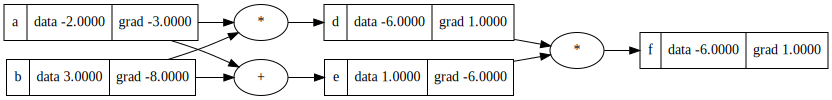

In [32]:
a = Value(-2.0, label = 'a')
b = Value(3.0, label = 'b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'
f.backward()
draw_dot(f)

In [49]:
a = Value(1.0)
a * 2

Value(data=2.0)

In [48]:
a = Value(2.0)
3 + a

Value(data=5.0)

In [51]:
a = Value(2.0)
a.exp()

Value(data=7.38905609893065)

In [54]:
a = Value(2.0)
3
a / 3

Value(data=0.6666666666666666)

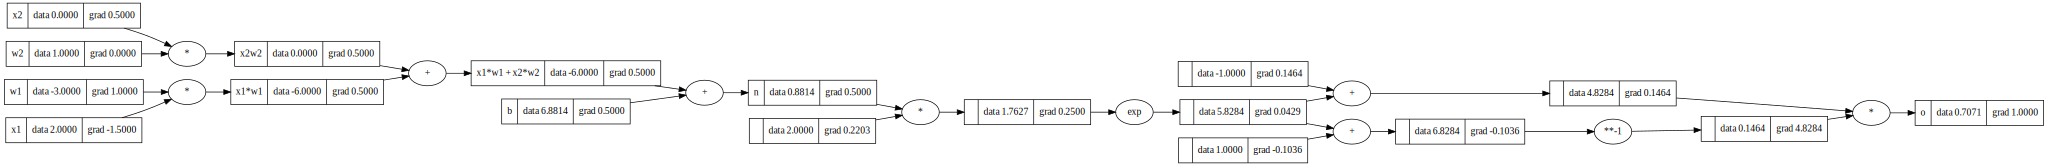

In [58]:
# inputs x1, x2
x1 = Value(2.0, label = "x1")
x2 = Value(0.0, label = "x2")

# weights w1, w2
w1 = Value(-3.0, label = "w1")
w2 = Value(1.0, label = "w2")

b = Value(6.8813735870195432, label = "b")

# x1 * w1 + x2 * w2 + b
x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label = "n"
# ----------
e = (2*n).exp()
o = (e - 1) / (e + 1)
# -----------
o.label = 'o'
o.backward()
draw_dot(o)

Now let's do this same thing, but in Pytorch

In [60]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()
print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [87]:
import random

class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi* xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

Value(data=0.7956344284433348)

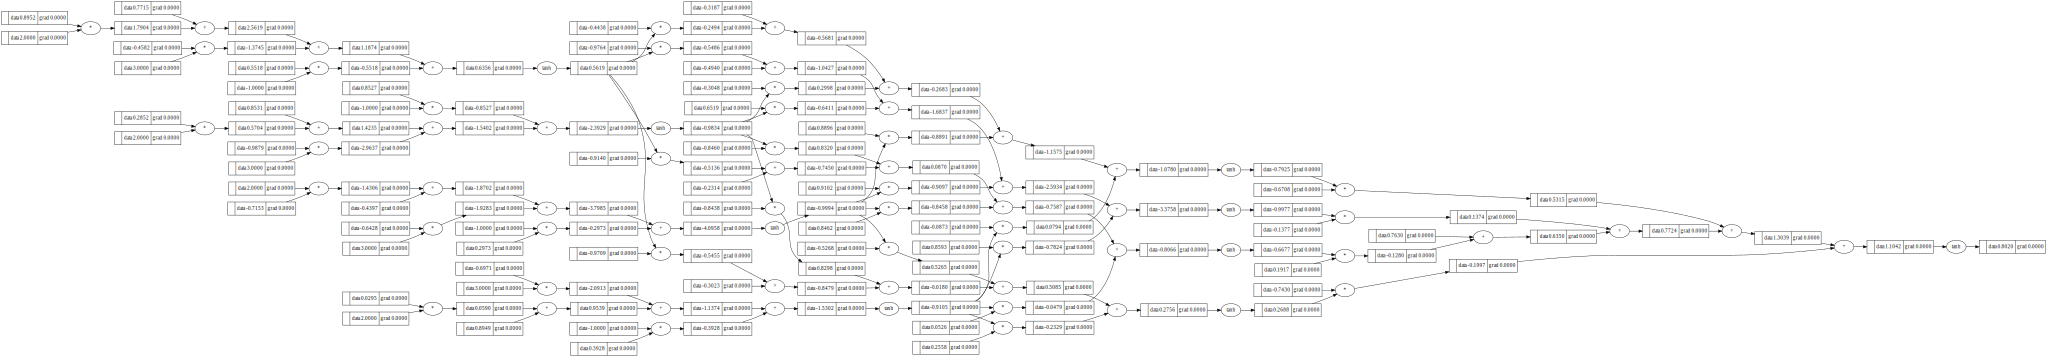

In [88]:
x = [2.0, 3.0, -1]
n = MLP(3, [4, 4, 1])
n(x)
draw_dot(n(x))

In [89]:
n.parameters()

[Value(data=0.8952243455993822),
 Value(data=-0.458179747286507),
 Value(data=0.5517883495297156),
 Value(data=0.7714503272351696),
 Value(data=0.28518949019838935),
 Value(data=-0.9878972191791737),
 Value(data=0.8527119847584927),
 Value(data=0.853146786767021),
 Value(data=-0.7152893153774638),
 Value(data=-0.642766321847589),
 Value(data=0.29726123097242163),
 Value(data=-0.4396573273542783),
 Value(data=0.02950303213344818),
 Value(data=-0.6971077181943488),
 Value(data=0.3928176236829648),
 Value(data=0.8949050884906256),
 Value(data=-0.9140371584739935),
 Value(data=-0.8460370197283635),
 Value(data=0.8462249752803566),
 Value(data=0.052589984349988406),
 Value(data=-0.23143948398297698),
 Value(data=-0.9764055965897966),
 Value(data=0.6518669795939682),
 Value(data=0.9102081079543312),
 Value(data=0.859341275408434),
 Value(data=-0.49404743578456967),
 Value(data=-0.44381176017786506),
 Value(data=-0.3048292581164018),
 Value(data=0.8896287376649055),
 Value(data=-0.08725038676

In [90]:
xs = [[2.0, 3.0, -1.0], [3.0, -1.0, 0.5], [0.5, 1.0, 1.0], [1.0, 1.0, -1.0]]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=0.8019959947912841),
 Value(data=0.9617023450543597),
 Value(data=0.958354576005181),
 Value(data=0.841470062871457)]

In [91]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=7.747766062996879)

In [92]:
loss.backward()

In [93]:
n.layers[0].neurons[0].w[0].grad

-0.16497115409951416

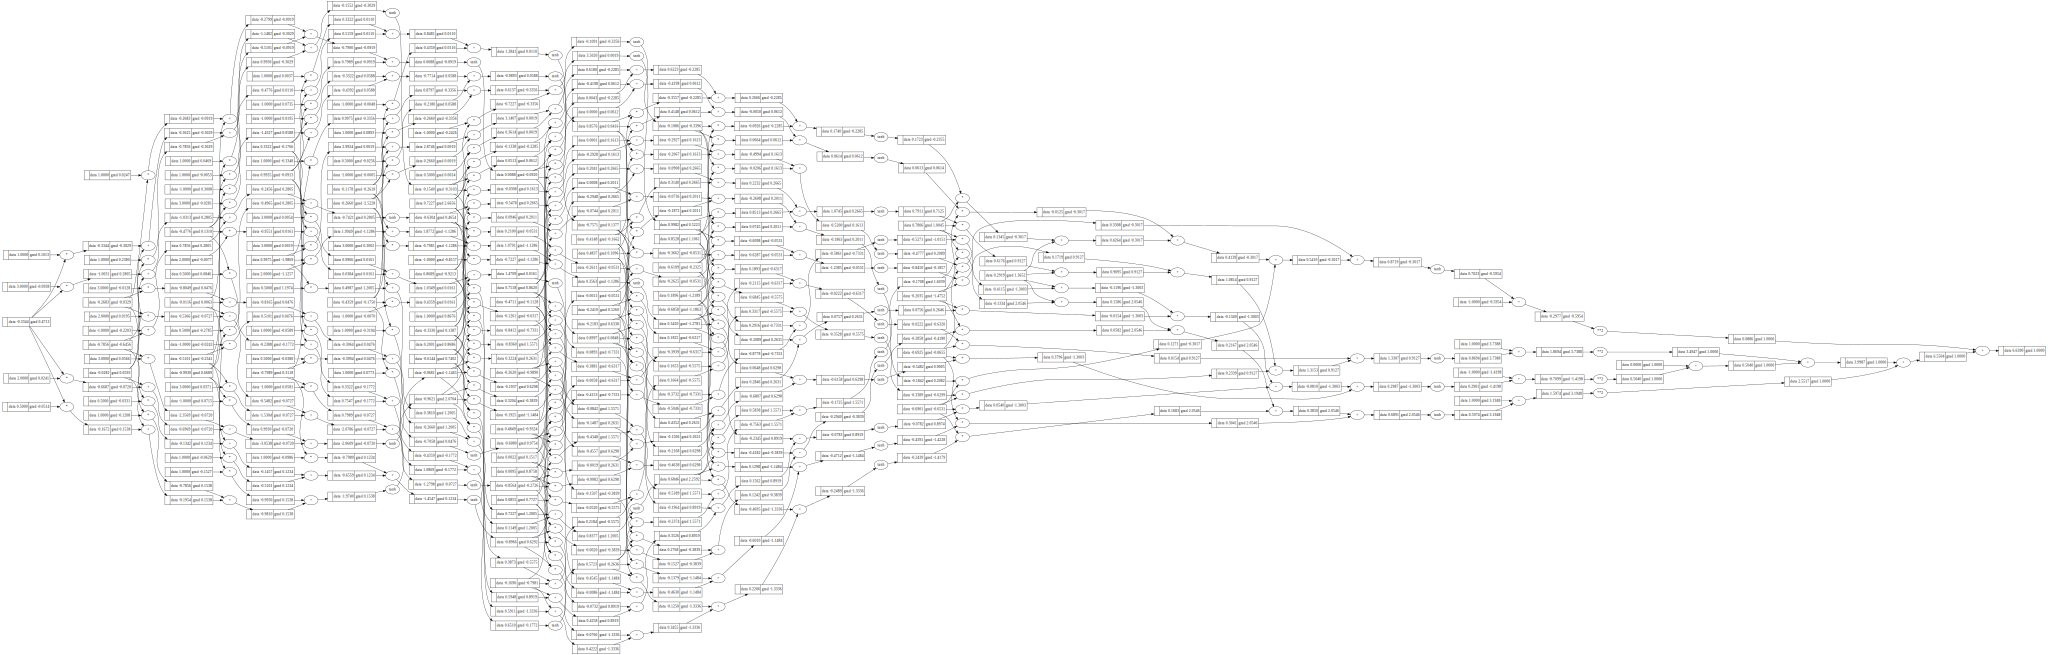

In [86]:
draw_dot(loss)

In [109]:
for p in n.parameters():
  p.data += -0.01 * p.grad

In [100]:
n.layers[0].neurons[0].w[1].grad

-0.2189056992753945

In [110]:
ypred = [n(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=7.5685596780082385)

In [111]:
loss.backward()

In [113]:
n.parameters()

[Value(data=0.9145862408801),
 Value(data=-0.43266241972600433),
 Value(data=0.5353634831688718),
 Value(data=0.7815549952703033),
 Value(data=0.2881411296638033),
 Value(data=-0.9865480376695798),
 Value(data=0.843819758344515),
 Value(data=0.8537985580329454),
 Value(data=-0.7150593225662273),
 Value(data=-0.6428676344050475),
 Value(data=0.296842231855432),
 Value(data=-0.4396626852150679),
 Value(data=0.029006202968409722),
 Value(data=-0.6980606408063453),
 Value(data=0.3980913972464898),
 Value(data=0.8955259563034353),
 Value(data=-0.9128584882861813),
 Value(data=-0.848801699261999),
 Value(data=0.8438923217480722),
 Value(data=0.050408789878599446),
 Value(data=-0.2291514958923109),
 Value(data=-0.9722610363950032),
 Value(data=0.655764513231148),
 Value(data=0.9063158446612455),
 Value(data=0.8628326338386758),
 Value(data=-0.48968464658634375),
 Value(data=-0.4426042270703724),
 Value(data=-0.2951002690659211),
 Value(data=0.8912980504282937),
 Value(data=-0.079416373319662)

In [124]:
x = [2.0, 3.0, -1]
n = MLP(3, [4, 4, 1])
n(x)

xs = [[2.0, 3.0, -1.0], [3.0, -1.0, 0.5], [0.5, 1.0, 1.0], [1.0, 1.0, -1.0]]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

for k in range(40):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k, loss.data)

0 4.825853021988056
1 4.104672927997744
2 4.020767467742611
3 2.0777417951149078
4 0.19200748817125035
5 0.11108438311583954
6 0.08395639010699811
7 0.06896239180251802
8 0.05905385113727135
9 0.05185772533112674
10 0.04632092969916811
11 0.04189300852438798
12 0.03825273988540799
13 0.0351972760688924
14 0.03259074886553127
15 0.030337936330625977
16 0.0283696774106235
17 0.02663427407846828
18 0.025092158896060472
19 0.02371244583113328
20 0.022470619251943862
21 0.021346938631030966
22 0.020325308831958478
23 0.019392462262669236
24 0.01853735531429189
25 0.01775071535539484
26 0.017024695605306922
27 0.016352608667807206
28 0.015728718321164077
29 0.015148075061488252
30 0.014606384925115429
31 0.01409990391547489
32 0.013625352337102402
33 0.013179844756372332
34 0.012760832337614377
35 0.012366055059928438
36 0.011993501882674736
37 0.011641377350415726
38 0.011308073448878672
39 0.010992145769104962


In [125]:
ypred

[Value(data=0.9546204516058738),
 Value(data=-0.9418632957036974),
 Value(data=-0.9480245230652119),
 Value(data=0.9466004141625077)]